In [231]:
# LOAD LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd

In [232]:
## load data
data = pd.read_csv('../data/output/final_database.csv')
data.columns

# date as datetime
data['Date'] = pd.to_datetime(data['Date'])

In [233]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

feature_cols = [
                'GDPV', 'IRL', 'IRS', 'GDP', 'CPIH_YTYPCT', 'IRCB', 'UNR',
                'YPH', 'UNR_us',  'CPI_us', 'High_minus_Low', 'Close_minus_Open',
                'SMA_5', 'SMA_10', 'SMA_20', 'WMA_5', 'WMA_10', 'WMA_20', 'Momentum',
                'RSI', 'Williams_R', 'Stochastic_K', 'Stochastic_D', 'CCI', 'MACD']

# Select only the columns in `feature_cols` for features
X = data[feature_cols]

# Define the target variable
y = data['Close'].copy()  # Adjust this if your target variable column is named differently
y = y

year = data['Date'].dt.year

X_train =  scaler.fit_transform(X[year < 2023])
X_test = scaler.transform(X[year >= 2023])

y_test = y[year >= 2023].reset_index(drop=True)
y_train = y[year < 2023].reset_index(drop=True)

In [234]:
#Linear Regression
lambda_grid = np.logspace(-2, 4, 50)
ridge_cv = RidgeCV(alphas=lambda_grid,fit_intercept=True).fit(X_train, y_train) #to perform cross validation

In [235]:
X_train.shape

(5879, 25)

In [236]:
# Extract the best alpha (lambda) value
optimal_alpha = ridge_cv.alpha_
print(f"Optimal Alpha (Regularization Strength): {optimal_alpha}")

# Coefficients of the model
coefficients = ridge_cv.coef_
intercept = ridge_cv.intercept_

# Predictions on the train and test sets
y_train_pred = ridge_cv.predict(X_train)
y_test_pred = ridge_cv.predict(X_test)

# Performance metrics for the training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_r_squared = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = train_mse ** 0.5

# Performance metrics for the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_r_squared = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = test_mse ** 0.5

# Prepare the data for the summary table
summary_table = {
    "Metric": ["R²", "MSE", "RMSE", "MAE"],
    "Train": [train_r_squared, train_mse, train_rmse, train_mae],
    "Test": [test_r_squared, test_mse, test_rmse, test_mae]
}

summary_table = pd.DataFrame(summary_table)
print(summary_table)

Optimal Alpha (Regularization Strength): 0.01
  Metric        Train         Test
0     R²     0.996414     0.962771
1    MSE  3918.340188  4223.897980
2   RMSE    62.596647    64.991522
3    MAE    44.667368    49.137334


As one can see, there is a significant difference between the training and test performance metrics. This is a clear indication that the model is overfitting the training data.

In [237]:
# Filter feature columns to exclude "Close"
filtered_features = [var for var in feature_cols if var != "Close"]

# Create a DataFrame for coefficients and variables
coef_df = pd.DataFrame({
    "Variable": feature_cols,
    "Coefficient": coefficients
})

In [238]:
print(coef_df.sort_values(by="Coefficient", ascending=False))

            Variable  Coefficient
15             WMA_5  2095.220148
17            WMA_20   920.993643
3                GDP    29.348018
9             CPI_us    20.683423
5               IRCB    20.326542
18          Momentum    16.616705
11  Close_minus_Open    13.227095
21      Stochastic_K    12.906515
19               RSI     9.313258
0               GDPV     6.568501
6                UNR     5.609769
1                IRL     4.575452
23               CCI     2.336262
10    High_minus_Low     0.389142
16            WMA_10    -1.110052
8             UNR_us    -5.101922
4        CPIH_YTYPCT    -5.299015
24              MACD    -9.009702
20        Williams_R   -12.906515
2                IRS   -17.716026
22      Stochastic_D   -29.735741
7                YPH   -48.135495
13            SMA_10  -188.257022
14            SMA_20  -419.740273
12             SMA_5 -1372.619173


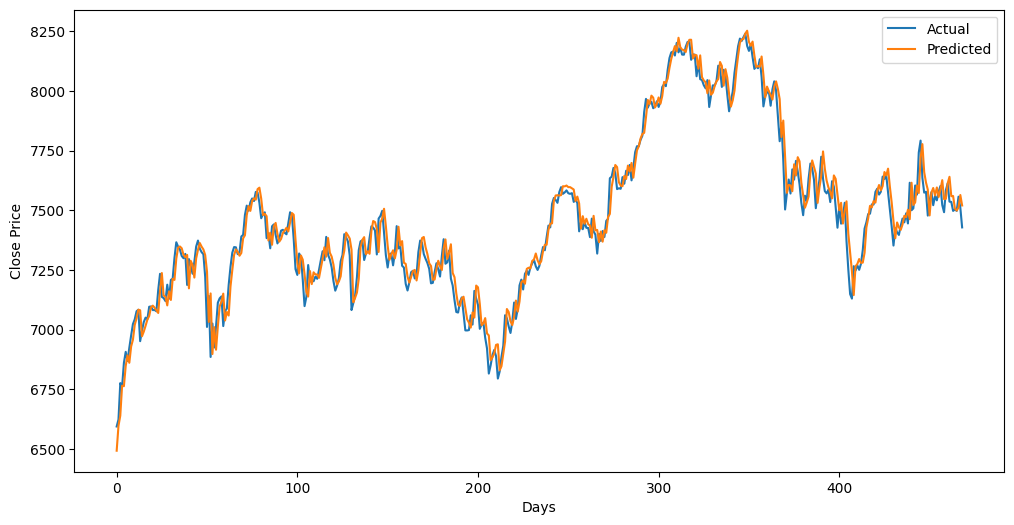

In [239]:
# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()


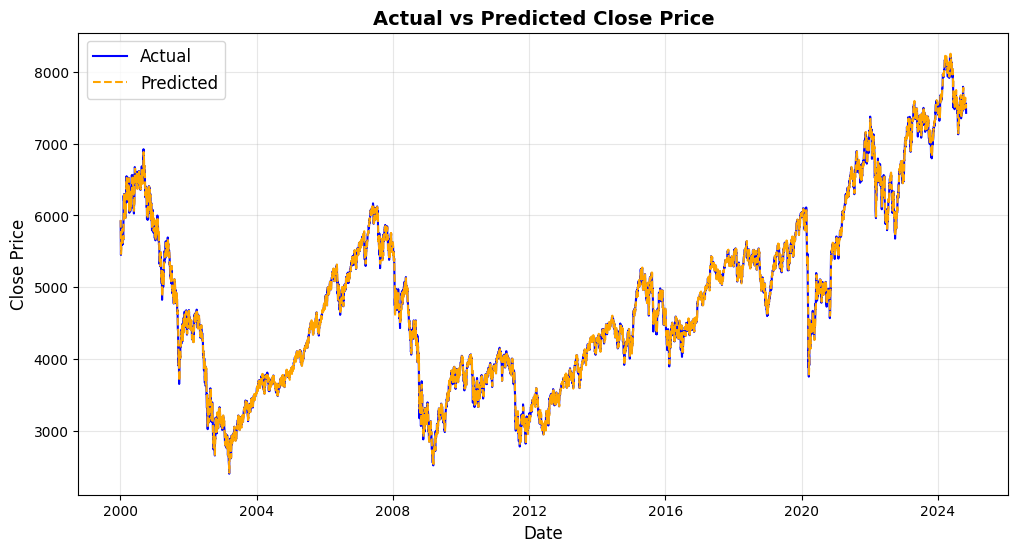

In [240]:
## Plot on all datatset

predictions = pd.Series(np.concatenate([y_train_pred, y_test_pred]), index=data["Date"])
actual = data["Close"]
plt.figure(figsize=(12, 6))
# Customize colors for actual and predicted
plt.plot(data["Date"], actual, label='Actual', color='blue', linewidth=1.5)  # Blue for actual
plt.plot(data["Date"], predictions, label='Predicted', color='orange', linestyle='--', linewidth=1.5)  # Orange dashed for predicted

# Add labels, legend, and grid
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.title('Actual vs Predicted Close Price', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()


We might be interested in the contribution of each feature of the model by using the shapley values. The shapley values are used to explain the prediction of the model. The shapley values are calculated by using the shap library. The shap library is a unified approach to explain the output of any machine learning

In [244]:
import shap

# Explain the model predictions using SHAP Linear Explainer
explainer = shap.Explainer(ridge_cv, X_train)  # SHAP Linear Explainer
shap_values = explainer(X_train)  # Compute SHAP values for the train set
shap_values.index = feature_cols

The idea behind SHAP feature importance is simple. 
- Features with large absolute Shapley values are important. Since we want the global importance, we average the absolute Shapley values per feature across the data.

- Next, we sort the features by decreasing importance and plot them. The following figure shows the SHAP feature importance for the trained random forest mode

The variable WMA_5 was the most important feature, changing the predicted median_house_value on average by 1750 on x-axis.

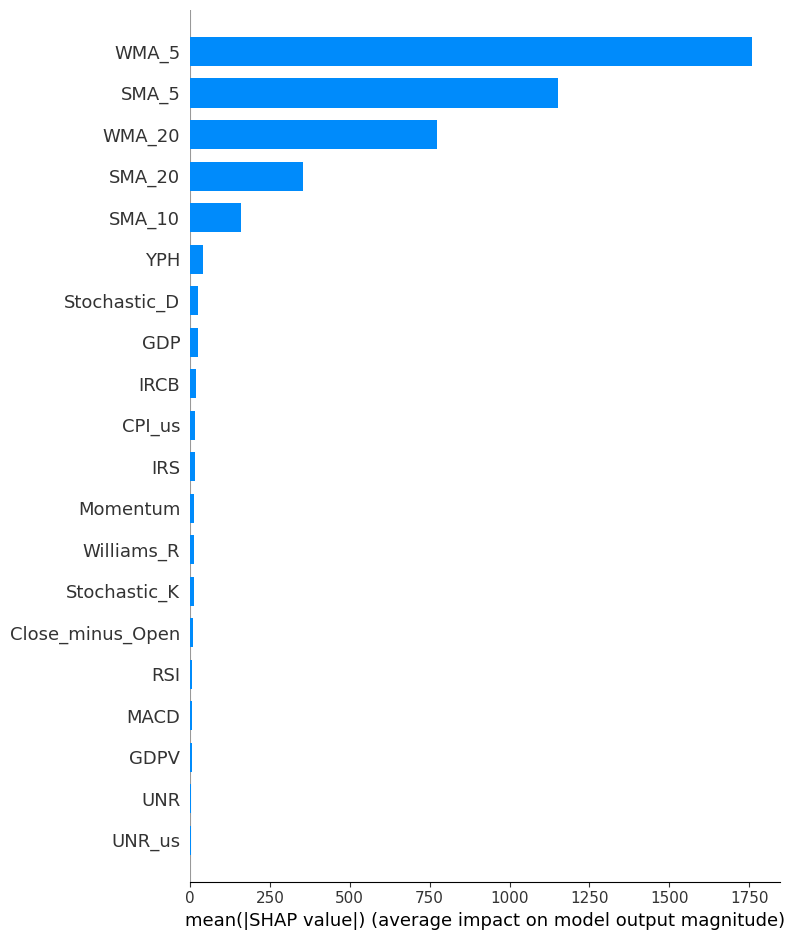

In [247]:
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=feature_cols)

The summary plot combines feature importance with feature effects. 
- Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value.
- The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

This plot is made of all the dots in the train data. It demonstrates the following information:

- Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.

The most important features are short-term and medium-term moving averages (WMA_5, SMA_5, and WMA_20), which significantly influence the model's predictions. for WMA_5, both high and low values have varying impacts, indicating a complex relationship with the target. For SMA_20, higher values tend to positively contribute, while lower values contribute negatively

Features like YPH and Stochastic_D have lower contributions, suggesting they are less important for this prediction task.

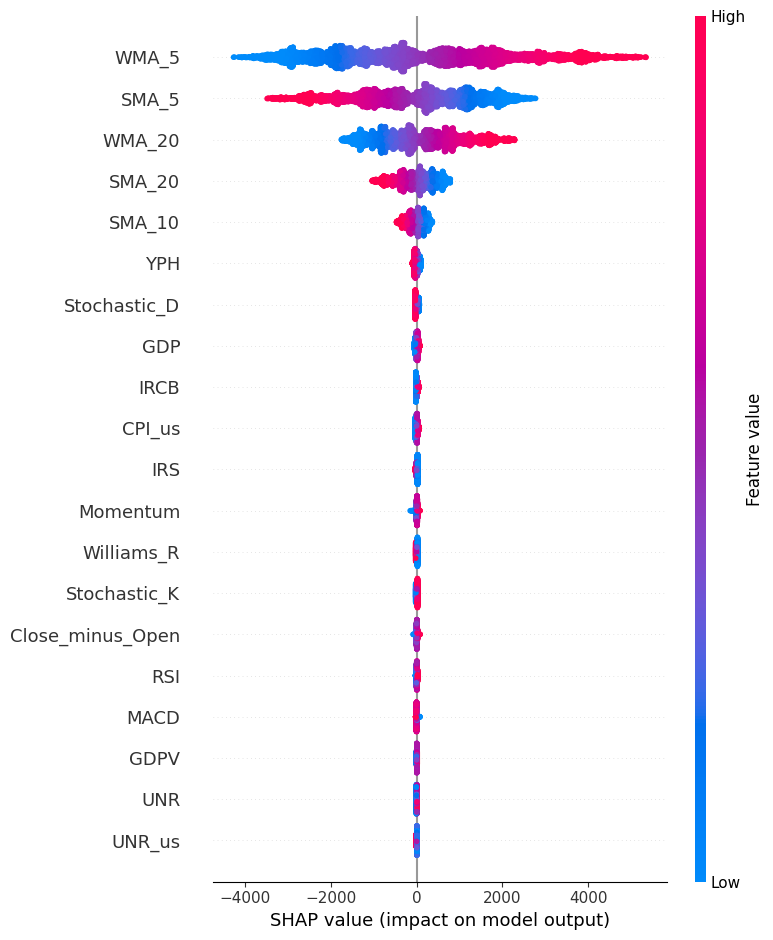

In [245]:
# Visualize the SHAP summary plot
shap.summary_plot(shap_values, X_train, feature_names=feature_cols)


# GARCH on residuals

In [100]:
residuals_train = y_train_pred - y_train
residuals_test = y_test_pred - y_test

Text(0.5, 0, 'Residuals')

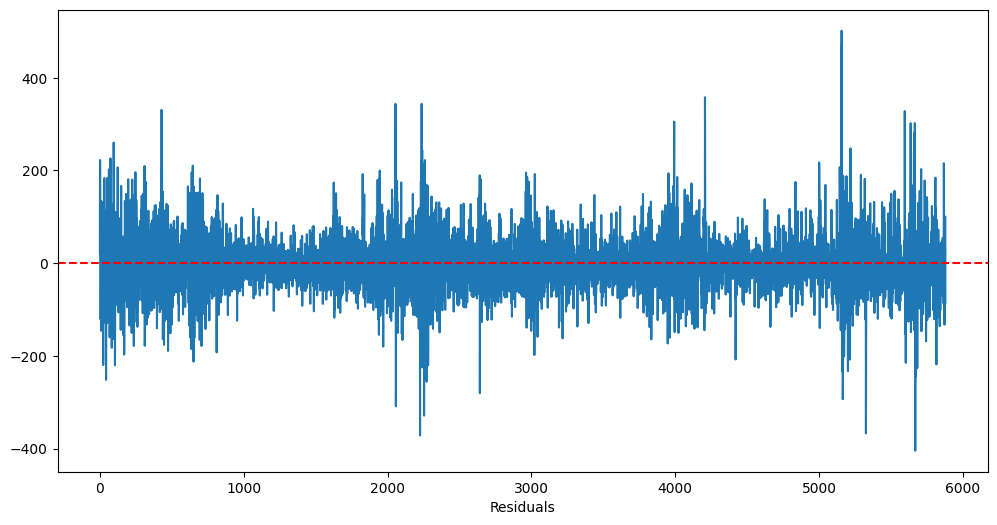

In [101]:
# Plot line the residuals of train
plt.figure(figsize=(12, 6))
plt.plot(residuals_train, label='Train Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Residuals')


In [102]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an Adataset report
    """
    print('Augmented Dickey-Fuller Test: {}\n'.format(title))
    # .dropna() handles differenced data
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['Adataset test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    # .to_string() removes the line "dtype: float64"
    print(f'{out.to_string()}\n')          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
adf_test(residuals_train, title='Train Residuals')

Augmented Dickey-Fuller Test: Train Residuals

Adataset test statistic   -1.374688e+01
p-value                    1.068463e-25
# lags used                3.000000e+01
# observations             5.848000e+03
critical value (1%)       -3.431469e+00
critical value (5%)       -2.862034e+00
critical value (10%)      -2.567033e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


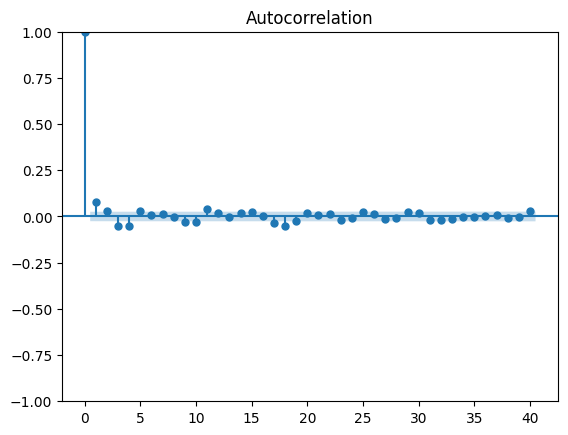

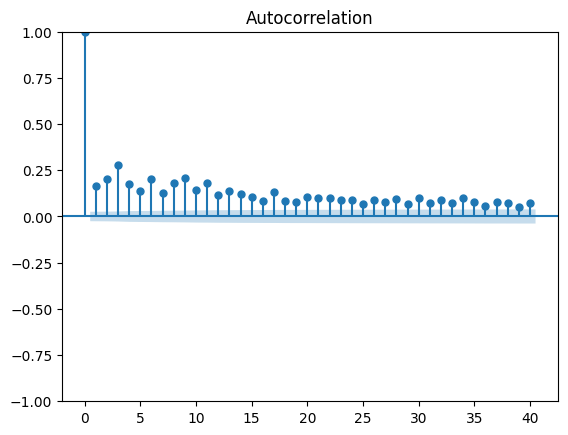

In [103]:
# Step 1 : Check for evidence for GARCH effects
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals_train, lags=40)
plot_acf(residuals_train**2, lags=40)
plt.show()

The residuals seems to exhibit some autocorrelation, which means that the residuals is not independant and identically distributed. This is a violation of the assumption of the ridge regression model (i.e. the homoscedasticity assumption). Hence, we will use a GARCH model to model the residuals. This will allow us to account for the autocorrelation in the residuals.

In [106]:
residuals_combined = np.concatenate([residuals_train, residuals_test])
residuals = pd.DataFrame({'residuals': residuals_combined})
residuals["Date"] = data["Date"]

residuals.isna().sum()

residuals    0
Date         0
dtype: int64

Text(0.5, 1.0, 'Residuals over Time')

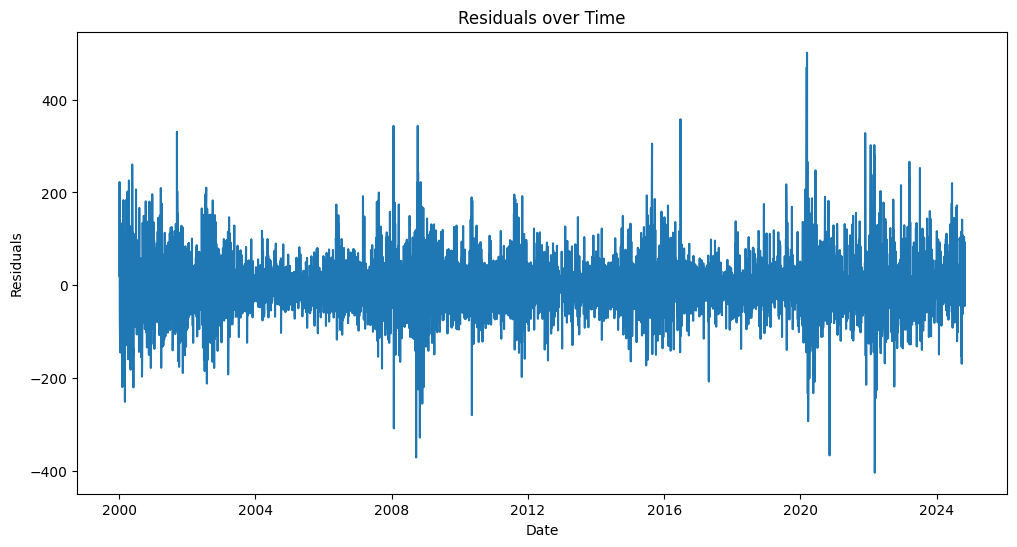

In [108]:
# plot
plt.figure(figsize=(12, 6))
plt.plot(residuals["Date"], residuals["residuals"])
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals over Time')


## 1. GARCH with normal distribution

In [149]:
# Step 2: Fit GARCH to Residuals
from arch import arch_model
garch_model = arch_model(residuals['residuals'].values, vol='Garch', p=1, q=1, dist='normal')
garch_fit = garch_model.fit(disp="off", last_obs=len(residuals_train),first_obs=0)

# Display GARCH summary
print(garch_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -31877.1
Distribution:                  Normal   AIC:                           63762.2
Method:            Maximum Likelihood   BIC:                           63788.9
                                        No. Observations:                 5879
Date:                Sun, Jan 12 2025   Df Residuals:                     5878
Time:                        03:49:46   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -1.5580      0.693     -2.248  2.457e-02 [ -2.916, -0.20

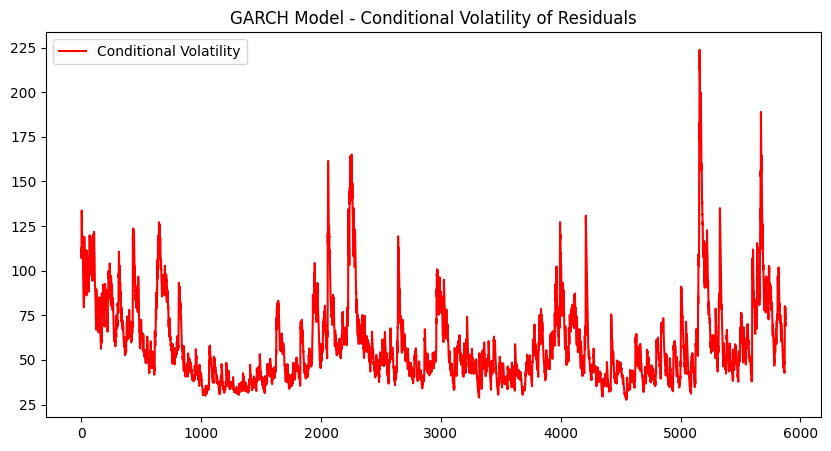

In [150]:

# Step 3: Plot Conditional Volatility
plt.figure(figsize=(10, 5))
plt.plot(garch_fit.conditional_volatility, label='Conditional Volatility', color='red')
plt.title('GARCH Model - Conditional Volatility of Residuals')
plt.legend()
plt.show()

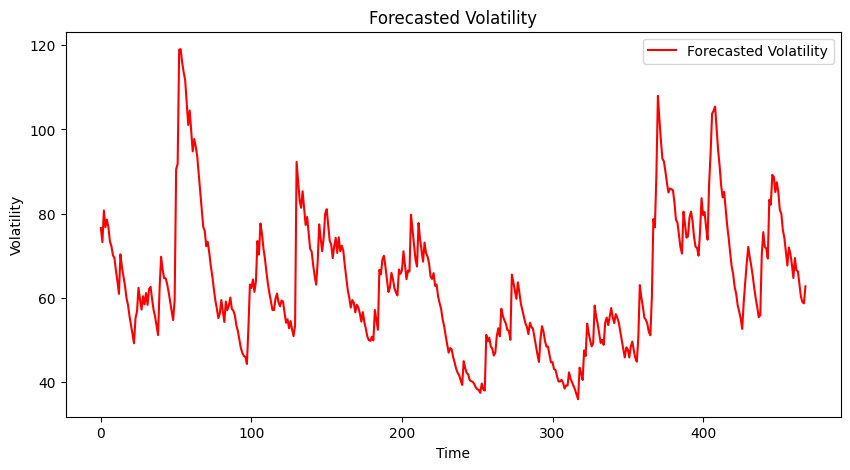

In [151]:
# Step 4: Forecast Volatility
# Forecast volatility for the test set
forecast = garch_fit.forecast(horizon=len(residuals_test), reindex=False)

# Extract forecasted variance for the test set and compute volatility
forecast_volatility = np.sqrt(forecast.variance.values[-len(residuals_test):, 0])

# Plot the forecasted volatility
plt.figure(figsize=(10, 5))
plt.plot(forecast_volatility, label='Forecasted Volatility', color='red')
plt.title('Forecasted Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()


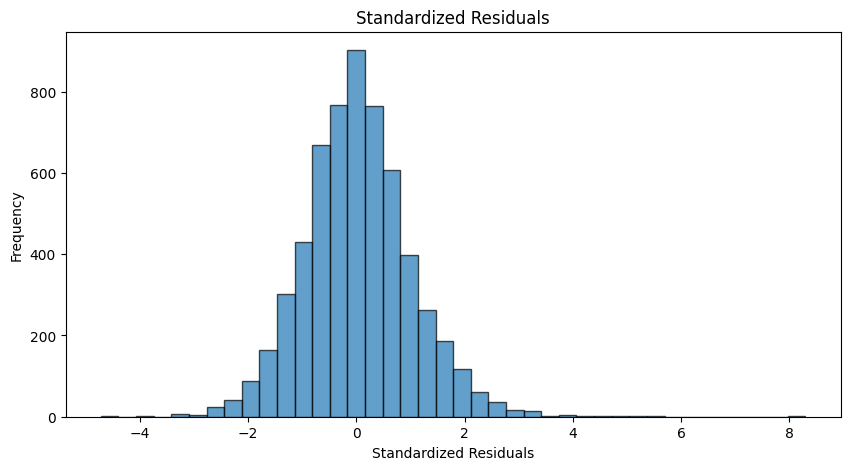

In [152]:
# Step 5 : check for normality of standardized residuals
# Standardize residuals
standardized_residuals = pd.Series(garch_fit.resid / garch_fit.conditional_volatility).dropna()

# Plot the standardized residuals
plt.figure(figsize=(10, 5))
plt.hist(standardized_residuals, bins=40, edgecolor='k', alpha=0.7)
plt.title('Standardized Residuals')
plt.xlabel('Standardized Residuals')
plt.ylabel('Frequency')
plt.show()


In [249]:
# compute kurtosis and skewness
from scipy.stats import kurtosis, skew

kurt = kurtosis(standardized_residuals)
skewness = skew(standardized_residuals)

print(f"Kurtosis: {kurt}")
print(f"Skewness: {skewness}")


Kurtosis: 4.439153612274353
Skewness: -0.33521712589244407


In [153]:
# Jarque-Bera test for normality
from scipy.stats import jarque_bera

jb_test = jarque_bera(standardized_residuals)
print(f"Jarque-Bera test statistic: {jb_test[0]}")
print(f"Jarque-Bera p-value: {jb_test[1]}")

# null hypothesis : residuals are normally distributed

Jarque-Bera test statistic: 1078.1585074958514
Jarque-Bera p-value: 7.600720957902619e-235


In [154]:
# Step 6 : check for non correlation of standardized residuals (Ljung-Box test for autocorrelation)
from statsmodels.stats.diagnostic import acorr_ljungbox

for i in range(1, 11):
    lb_test = acorr_ljungbox(standardized_residuals, lags=i)
    print(f"Ljung-Box test statistic (lag={i}): {lb_test['lb_stat']}")
    print(f"Ljung-Box p-value (lag={i}): {lb_test['lb_pvalue']}")

Ljung-Box test statistic (lag=1): 1    0.263351
Name: lb_stat, dtype: float64
Ljung-Box p-value (lag=1): 1    0.607827
Name: lb_pvalue, dtype: float64
Ljung-Box test statistic (lag=2): 1    0.263351
2    0.816688
Name: lb_stat, dtype: float64
Ljung-Box p-value (lag=2): 1    0.607827
2    0.664750
Name: lb_pvalue, dtype: float64
Ljung-Box test statistic (lag=3): 1    0.263351
2    0.816688
3    7.097482
Name: lb_stat, dtype: float64
Ljung-Box p-value (lag=3): 1    0.607827
2    0.664750
3    0.068855
Name: lb_pvalue, dtype: float64
Ljung-Box test statistic (lag=4): 1     0.263351
2     0.816688
3     7.097482
4    24.675085
Name: lb_stat, dtype: float64
Ljung-Box p-value (lag=4): 1    0.607827
2    0.664750
3    0.068855
4    0.000058
Name: lb_pvalue, dtype: float64
Ljung-Box test statistic (lag=5): 1     0.263351
2     0.816688
3     7.097482
4    24.675085
5    29.353299
Name: lb_stat, dtype: float64
Ljung-Box p-value (lag=5): 1    0.607827
2    0.664750
3    0.068855
4    0.000058
5 

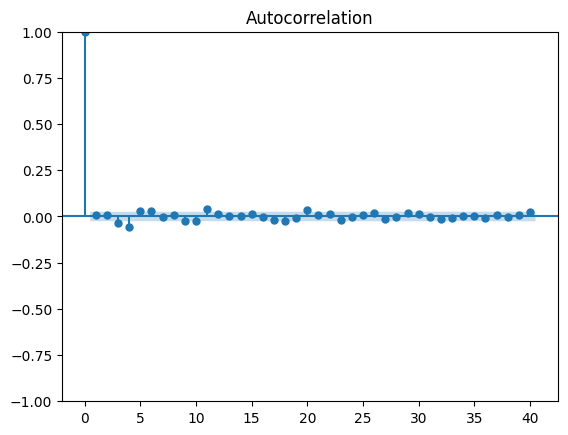

In [155]:
plot_acf(standardized_residuals, lags=40)
plt.show()

## 2. Check distribution of standardized residuals

In [250]:
from scipy.stats import kstest, t, norm, genextreme
import numpy as np

# Assuming standardized_residuals contains the data
# Replace the following mock data with your actual standardized residuals
np.random.seed(42)
standardized_residuals = np.random.standard_t(df=4, size=1000)  # Example data

# Fit different distributions
# Fit Normal Distribution
norm_params = norm.fit(standardized_residuals)

# Fit Student's t-distribution
t_params = t.fit(standardized_residuals)

# Fit Generalized Error Distribution (approximated as generalized extreme value distribution for demonstration)
ged_params = genextreme.fit(standardized_residuals)

# Perform KS Tests
ks_norm_stat, ks_norm_p = kstest(standardized_residuals, 'norm', args=norm_params)
ks_t_stat, ks_t_p = kstest(standardized_residuals, 't', args=(t_params[0], t_params[1], t_params[2]))
ks_ged_stat, ks_ged_p = kstest(standardized_residuals, 'genextreme', args=ged_params)

# Results Summary
results = {
    "Normal Distribution": {"KS Statistic": ks_norm_stat, "p-value": ks_norm_p},
    "Student's t-Distribution": {"KS Statistic": ks_t_stat, "p-value": ks_t_p},
    "Generalized Error Distribution": {"KS Statistic": ks_ged_stat, "p-value": ks_ged_p}
}

results_df = pd.DataFrame(results)
print(results_df)


              Normal Distribution  Student's t-Distribution  \
KS Statistic             0.051618                  0.017371   
p-value                  0.009353                  0.918263   

              Generalized Error Distribution  
KS Statistic                    9.070973e-02  
p-value                         1.306772e-07  


According to the ks-test, the results follow a t-distribution. The p-value is greater than 0.05, which indicates that the residuals are student-t distributed. We will use this information to fit the GARCH model.

## 3. GARCH Model with student t-distribution

In [157]:
# Step 2: Fit GARCH to Residuals
from arch import arch_model
garch_model_t = arch_model(residuals['residuals'].values, vol='Garch', p=1, q=1, dist='t')
garch_fit_t = garch_model_t.fit(disp="off", last_obs=len(residuals_train),first_obs=0)

# Display GARCH summary
print(garch_fit_t.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -31773.2
Distribution:      Standardized Student's t   AIC:                           63556.4
Method:                  Maximum Likelihood   BIC:                           63589.8
                                              No. Observations:                 5879
Date:                      Sun, Jan 12 2025   Df Residuals:                     5878
Time:                              03:49:51   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -2

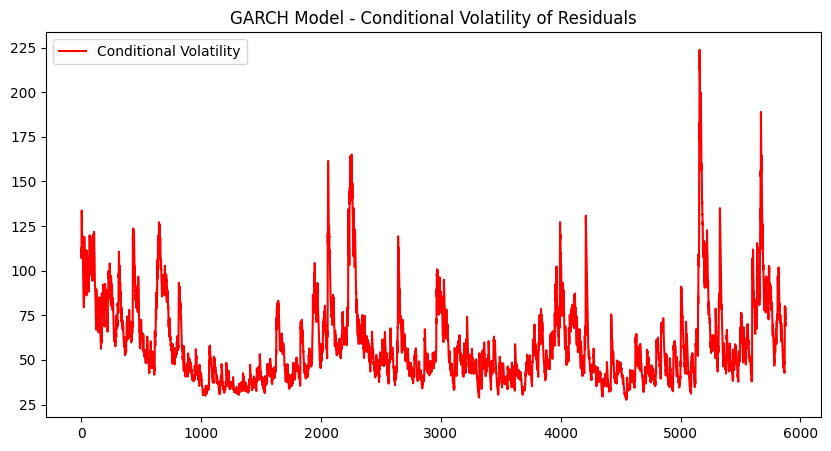

In [ ]:

# Step 3: Plot Conditional Volatility
plt.figure(figsize=(10, 5))
plt.plot(garch_fit.conditional_volatility, label='Conditional Volatility', color='red')
plt.title('GARCH Model - Conditional Volatility of Residuals')
plt.legend()
plt.show()

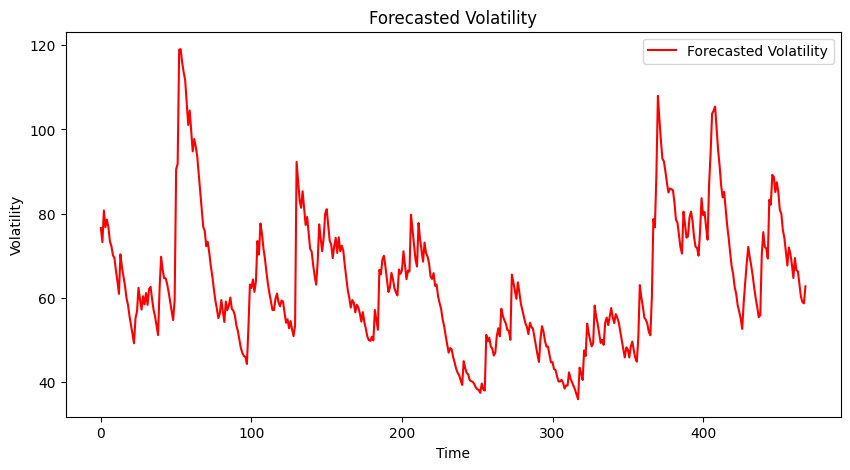

In [159]:
# Step 4: Forecast Volatility
# Forecast volatility for the test set
forecast = garch_fit.forecast(horizon=len(residuals_test), reindex=False)

# Extract forecasted variance for the test set and compute volatility
forecast_volatility = np.sqrt(forecast.variance.values[-len(residuals_test):, 0])

# Plot the forecasted volatility
plt.figure(figsize=(10, 5))
plt.plot(forecast_volatility, label='Forecasted Volatility', color='red')
plt.title('Forecasted Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()


In [161]:
## Compare the two models

# Get the AIC and BIC values for the two models
aic_bic = {
    "GARCH-Normal": [garch_fit.aic, garch_fit.bic],
    "GARCH-t": [garch_fit_t.aic, garch_fit_t.bic]
}

aic_bic_df = pd.DataFrame(aic_bic, index=["AIC", "BIC"])
print(aic_bic_df)

     GARCH-Normal       GARCH-t
AIC  63762.217272  63556.363687
BIC  63788.933840  63589.759397


In [257]:
# print series and volatility

vol_train = pd.Series(garch_fit.conditional_volatility).dropna()
vol_forecast = pd.Series(forecast_volatility).dropna()

volatility = pd.concat([vol_train, vol_forecast]).dropna()

volatility.index=residuals["Date"]

Text(0, 0.5, 'Close Price')

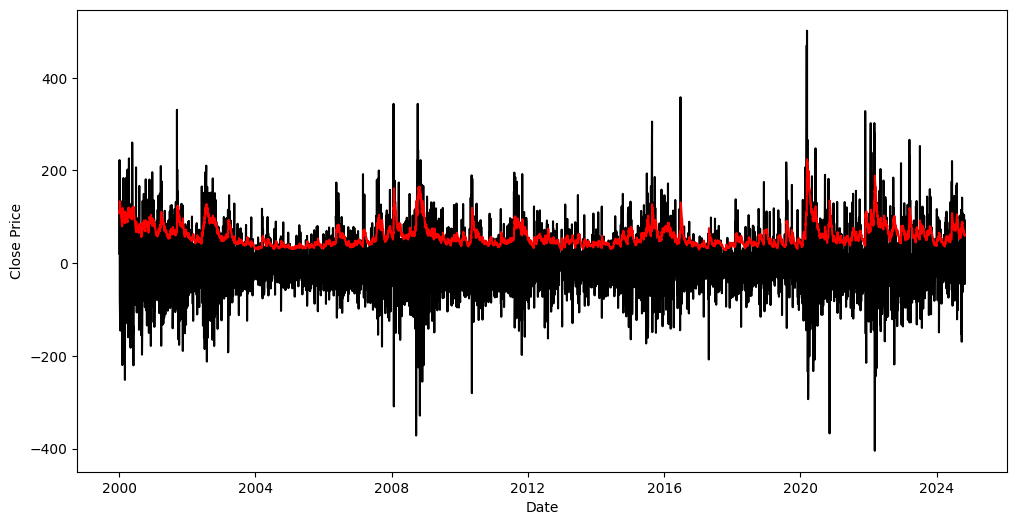

In [ ]:
# Plot the series and volatility

plt.figure(figsize=(12, 6))
plt.plot(residuals["Date"], residuals["residuals"], label='Close Price', color='black')
plt.plot(residuals["Date"], volatility, label='Volatility', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price and Volatility')